## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Metrics and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline

# Configuration
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
SEED = 42

print("Libraries imported and setup complete.")

Libraries imported and setup complete.


## 2. Load Datasets

In [ ]:
# Download/Locate Datasets
print("Checking datasets...")
try:
    path_smoker = kagglehub.dataset_download("gauravduttakiit/smoker-status-prediction-using-biosignals")
    path_forest = kagglehub.dataset_download("uciml/forest-cover-type-dataset")
    print(f"Smoker Dataset Path: {path_smoker}")
    print(f"Forest Dataset Path: {path_forest}")
    
    # Load Smoker Data
    smoker_df = pd.read_csv(os.path.join(path_smoker, 'train_dataset.csv'))
    
    # Load Forest Data
    forest_df = pd.read_csv(os.path.join(path_forest, 'covtype.csv'))
    
    print(f"Smoker Data Shape: {smoker_df.shape}")
    print(f"Forest Data Shape: {forest_df.shape}")
except Exception as e:
    print(f"Error loading datasets: {e}")

Checking datasets...
Smoker Dataset Path: /home/aditya-lahkar/.cache/kagglehub/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals/versions/1
Forest Dataset Path: /home/aditya-lahkar/.cache/kagglehub/datasets/uciml/forest-cover-type-dataset/versions/1
Smoker Data Shape: (38984, 23)
Forest Data Shape: (581012, 55)


# PART 1: Smoker Status Prediction (Binary Classification)

## EDA

--- Smoker Dataset EDA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobi

/tmp/ipykernel_25933/164123807.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='smoking', data=smoker_df, ax=axes[0, 0], palette='viridis')


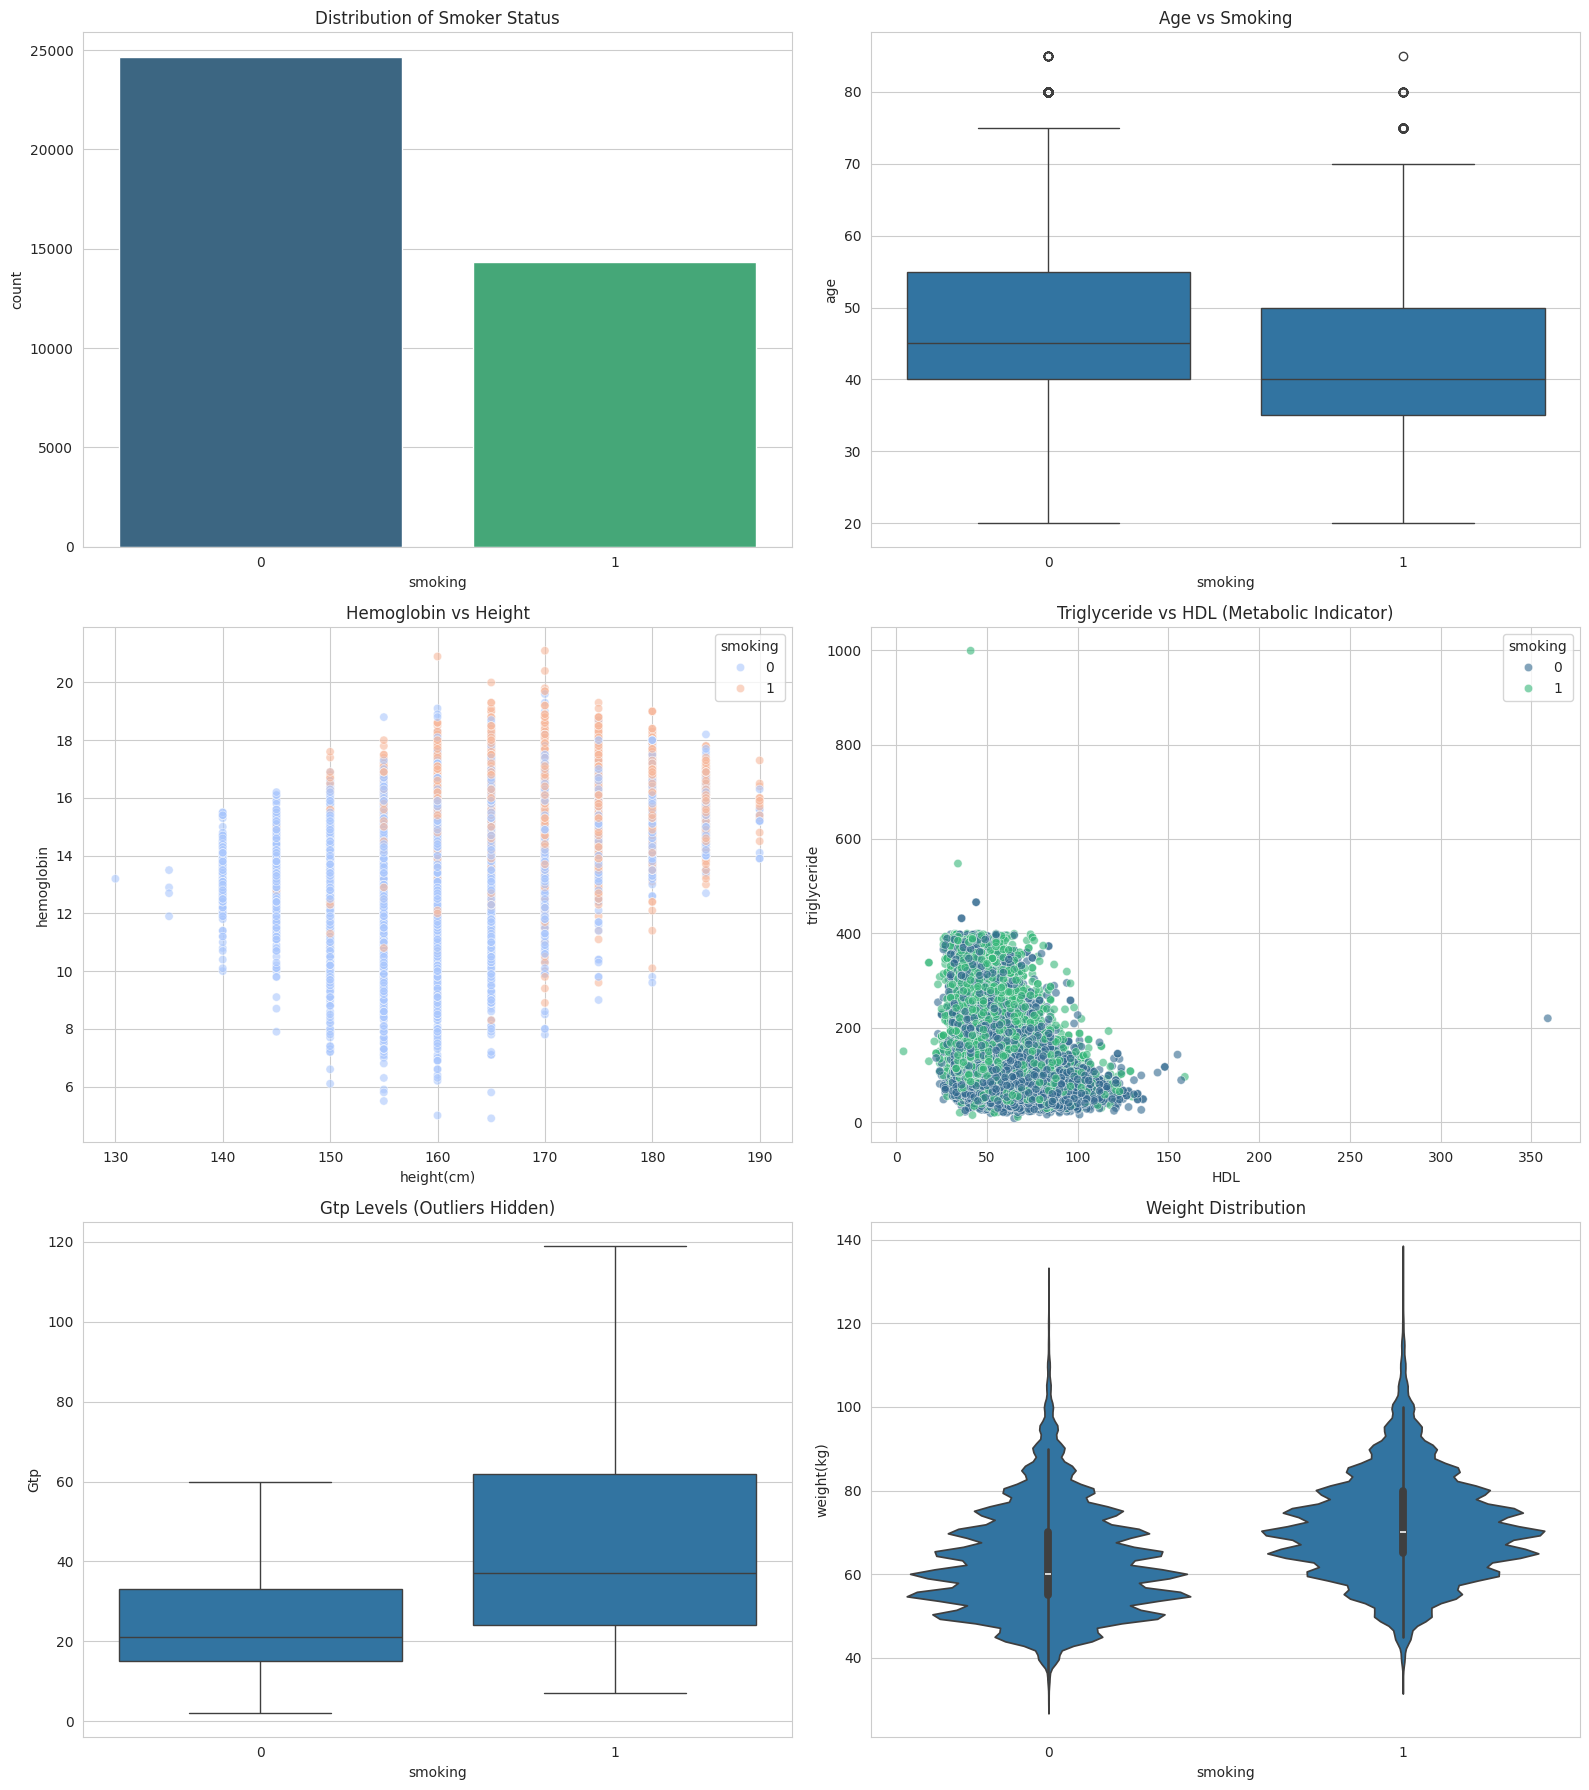


Mean Values by Smoking Status:
           age  height(cm)  weight(kg)  waist(cm)  hemoglobin  triglyceride  \
smoking                                                                       
0        45.66      161.93       63.00      80.47       14.15        113.02   
1        41.49      169.44       71.01      84.80       15.45        150.41   

           Gtp    HDL  
smoking                
0        30.81  59.29  
1        55.58  53.85  


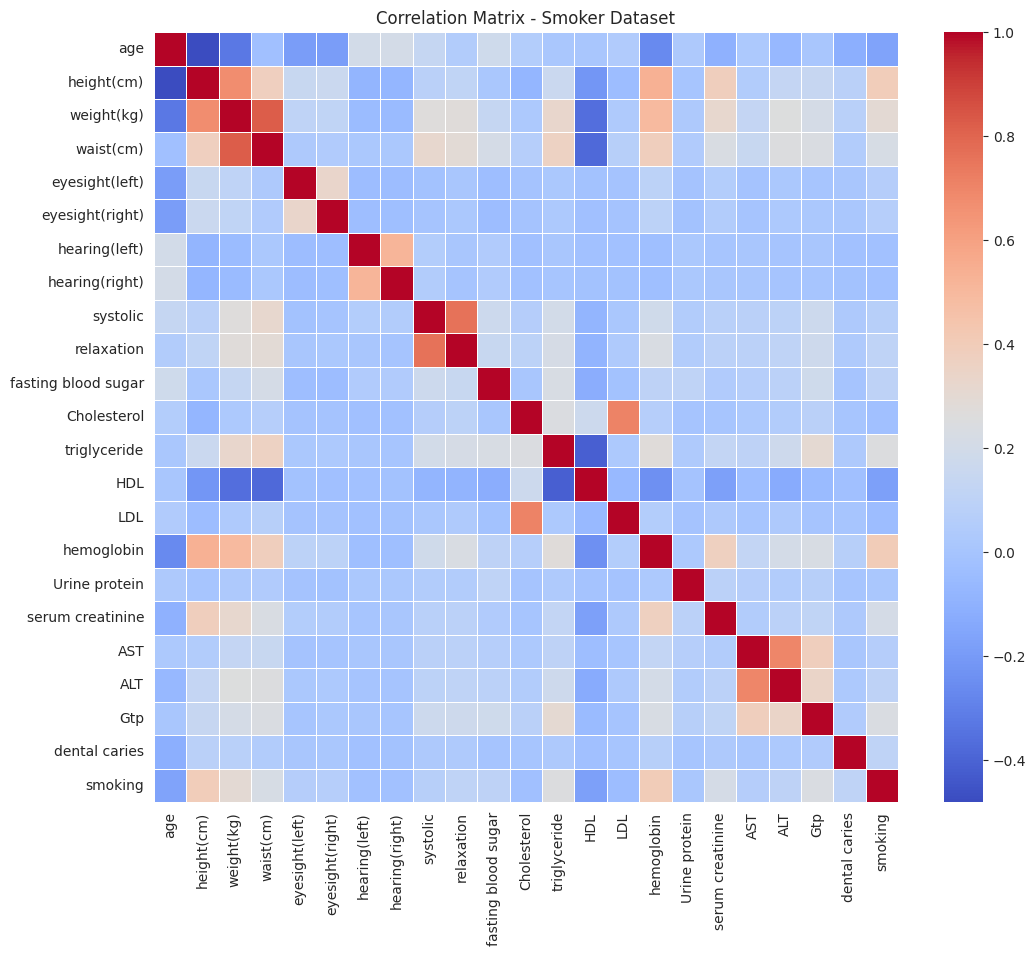

In [ ]:
print("--- Smoker Dataset EDA ---")
print(smoker_df.info())
print("\nMissing Values:\n", smoker_df.isnull().sum().sum())
print("\nTarget Distribution ('smoking'):")
print(smoker_df['smoking'].value_counts(normalize=True))

# Visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Plot 1: Target Count
sns.countplot(x='smoking', data=smoker_df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title("Distribution of Smoker Status")

# Plot 2: Age vs Smoking
sns.boxplot(x='smoking', y='age', data=smoker_df, ax=axes[0, 1])
axes[0, 1].set_title("Age vs Smoking")

# Plot 3: Hemoglobin vs Height 
sns.scatterplot(x='height(cm)', y='hemoglobin', hue='smoking', data=smoker_df, ax=axes[1, 0], alpha=0.6, palette='coolwarm')
axes[1, 0].set_title("Hemoglobin vs Height")

# Plot 4: Triglyceride vs HDL (Metabolic Health)
sns.scatterplot(x='HDL', y='triglyceride', hue='smoking', data=smoker_df, ax=axes[1, 1], alpha=0.6, palette='viridis')
axes[1, 1].set_title("Triglyceride vs HDL (Metabolic Indicator)")

# Plot 5: Gtp (Liver Enzyme)
sns.boxplot(x='smoking', y='Gtp', data=smoker_df, ax=axes[2, 0], showfliers=False)
axes[2, 0].set_title("Gtp Levels (Outliers Hidden)")

# Plot 6: Weight vs Smoking
sns.violinplot(x='smoking', y='weight(kg)', data=smoker_df, ax=axes[2, 1])
axes[2, 1].set_title("Weight Distribution")

plt.tight_layout()
plt.show()

# Statistical Summary
print("\nMean Values by Smoking Status:")
display_cols = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'hemoglobin', 'triglyceride', 'Gtp', 'HDL']
print(smoker_df.groupby('smoking')[display_cols].mean().round(2))

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(smoker_df.corr(numeric_only=True), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix - Smoker Dataset")
plt.show()

## Preprocessing

In [ ]:
# Feature Engineering & Preprocessing
from sklearn.preprocessing import RobustScaler # Better for data with outliers (like Gtp/Triglycerides)

# Feature Engineering
smoker_df['BMI'] = smoker_df['weight(kg)'] / ((smoker_df['height(cm)'] / 100) ** 2)

# Waist-to-Height Ratio (strong indicator of metabolic health)
smoker_df['WHtr'] = smoker_df['waist(cm)'] / smoker_df['height(cm)']

# Prepare X and y
X_smoker = smoker_df.drop(columns=['smoking'])
y_smoker = smoker_df['smoking']

# Split Data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoker, y_smoker, test_size=0.2, random_state=SEED, stratify=y_smoker)

# Scaling
scaler_s = RobustScaler()
X_train_s_scaled = scaler_s.fit_transform(X_train_s)
X_test_s_scaled = scaler_s.transform(X_test_s)

print("Smoker Dataset Preprocessed (with Feature Engineering).")
print(f"Added Features: BMI, WHtr")
print(f"Scaler: RobustScaler")
print(f"Train shape: {X_train_s_scaled.shape}, Test shape: {X_test_s_scaled.shape}")

Smoker Dataset Preprocessed (with Feature Engineering).
Added Features: BMI, WHtr
Scaler: RobustScaler
Train shape: (31187, 24), Test shape: (7797, 24)


## Model Training & Evaluation

In [ ]:
# Hyperparameter Tuning (RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV

# Parameter Grids
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ['lbfgs', 'liblinear']
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "gamma": ['scale', 'auto', 0.1, 0.01],
        "kernel": ['rbf'] 
    },
    "Neural Network": {
        "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
        "activation": ['tanh', 'relu'],
        "alpha": [0.0001, 0.001, 0.01],
        "learning_rate_init": [0.001, 0.01]
    }
}

base_models = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=2000),
    "SVM": SVC(probability=True, random_state=SEED), # probability=True is slow but needed for ROC-AUC if you compute it later
    "Neural Network": MLPClassifier(max_iter=1000, random_state=SEED)
}

results_smoker = []
best_models_smoker = {}

print("Starting Hyperparameter Tuning (Optimized)...")

for name, model in base_models.items():
    print(f"\n--- Tuning {name} ---")
    
    if len(X_train_s) > 5000:
        print(f"  > Subsampling to 5000 samples for faster tuning...")
        # Stratified subsample to preserve class ratios
        X_tune, _, y_tune, _ = train_test_split(X_train_s_scaled, y_train_s, train_size=5000, stratify=y_train_s, random_state=SEED)
    else:
        X_tune, y_tune = X_train_s_scaled, y_train_s

    search = RandomizedSearchCV(
        model, 
        param_grids[name], 
        n_iter=5,
        cv=3, 
        scoring='accuracy', 
        n_jobs=-1, 
        random_state=SEED, 
        verbose=1
    )
    
    search.fit(X_tune, y_tune)
    print(f"  > Best Params found: {search.best_params_}")
    print(f"  > Best CV Score (on subset): {search.best_score_:.4f}")
    
    print(f"  > Retraining best model on FULL training set ({len(X_train_s)} samples)...")
    best_model = search.best_estimator_
    best_model.fit(X_train_s_scaled, y_train_s)
    best_models_smoker[name] = best_model
    
    # Evaluate on Test Set
    y_pred = best_model.predict(X_test_s_scaled)
    
    accuracy = accuracy_score(y_test_s, y_pred)
    precision = precision_score(y_test_s, y_pred)
    recall = recall_score(y_test_s, y_pred)
    f1 = f1_score(y_test_s, y_pred)
    
    results_smoker.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Best Params": str(search.best_params_)
    })
    
    print(f"  > Final Test Accuracy: {accuracy:.4f}")

# Display Results
results_smoker_df = pd.DataFrame(results_smoker)
print("\n--- Smoker Dataset Tuned Results ---")
display_cols = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
print(results_smoker_df[display_cols])

Starting Hyperparameter Tuning (Optimized)...

--- Tuning Logistic Regression ---
  > Subsampling to 5000 samples for faster tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

  > Best Params found: {'solver': 'liblinear', 'C': 10}
  > Best CV Score (on subset): 0.7284
  > Retraining best model on FULL training set (31187 samples)...
  > Final Test Accuracy: 0.7177

--- Tuning SVM ---
  > Subsampling to 5000 samples for faster tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
  > Best Params found: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
  > Best CV Score (on subset): 0.7458
  > Retraining best model on FULL training set (31187 samples)...
  > Final Test Accuracy: 0.7532

--- Tuning Neural Network ---
  > Subsampling to 5000 samples for faster tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and 

  > Best Params found: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'relu'}
  > Best CV Score (on subset): 0.7210
  > Retraining best model on FULL training set (31187 samples)...
  > Final Test Accuracy: 0.7448

--- Smoker Dataset Tuned Results ---
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.717712   0.626963  0.571578  0.597991
1                  SVM  0.753238   0.666078  0.658170  0.662100
2       Neural Network  0.744774   0.657648  0.636522  0.646913


# PART 2: Forest Cover Type (Multiclass Classification)

## EDA

--- Forest Dataset EDA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2         

/tmp/ipykernel_25933/3111315860.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cover_Type', data=forest_df, ax=axes[0, 0], palette='viridis')
/tmp/ipykernel_25933/3111315860.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cover_Type', y='Elevation', data=forest_df, ax=axes[0, 1], palette='coolwarm')
/tmp/ipykernel_25933/3111315860.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cover_Type', y='Aspect', data=forest_df, ax=axes[1, 0], palette='muted')
/tmp/ipykernel_25933/3111315860.py:23: FutureWarning: 

Passing

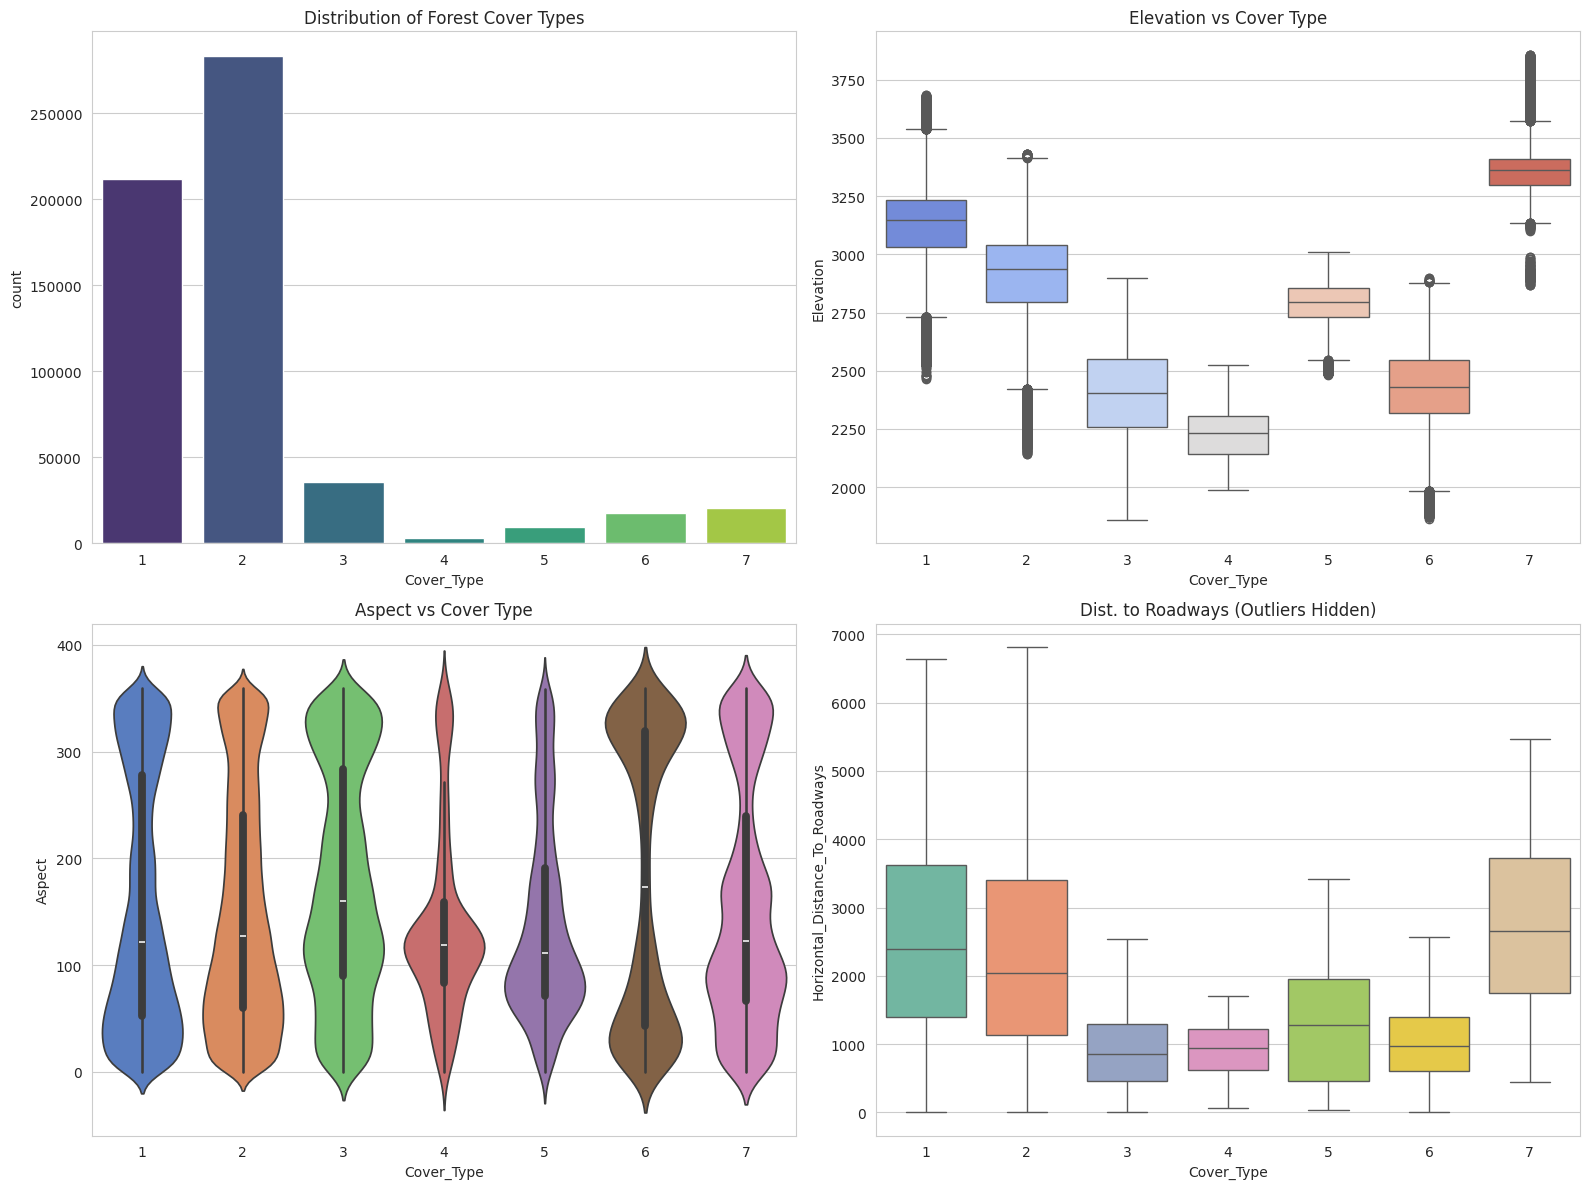

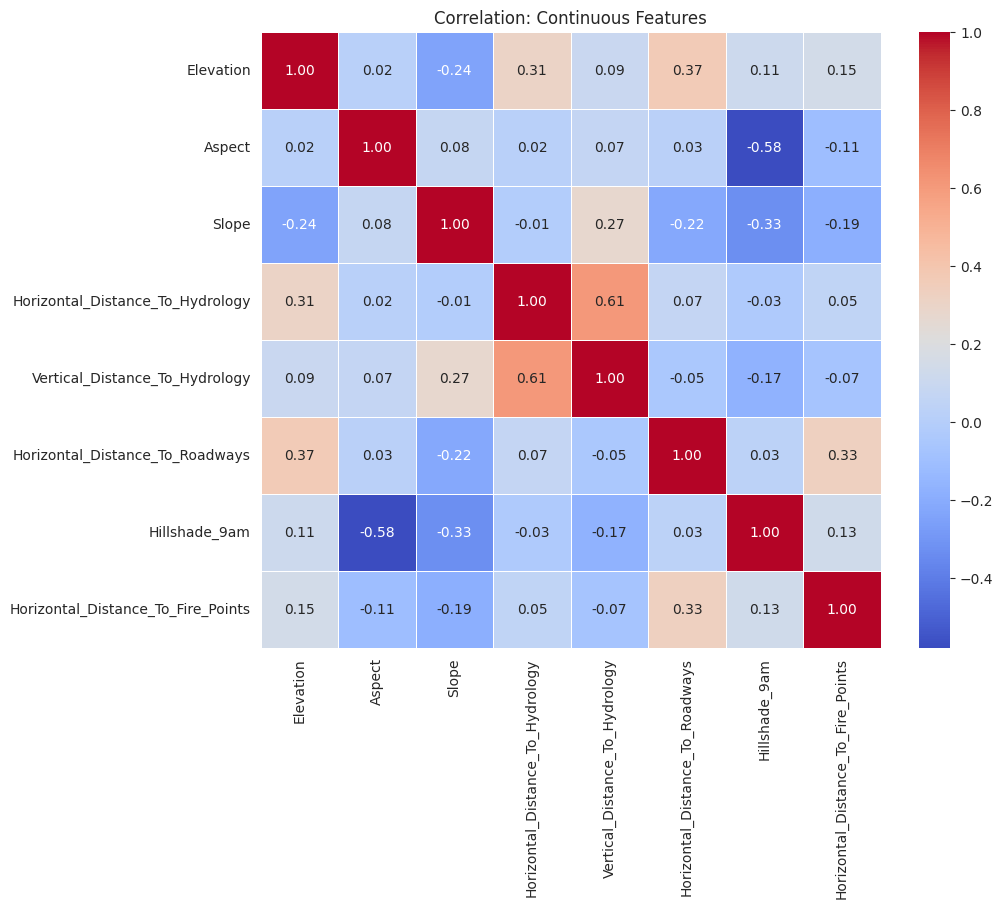

In [ ]:
print("--- Forest Dataset EDA ---")
print(forest_df.info())
print("\nTarget Distribution ('Cover_Type'):")
print(forest_df['Cover_Type'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Target Count
sns.countplot(x='Cover_Type', data=forest_df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title("Distribution of Forest Cover Types")

# Elevation vs Cover Type 
sns.boxplot(x='Cover_Type', y='Elevation', data=forest_df, ax=axes[0, 1], palette='coolwarm')
axes[0, 1].set_title("Elevation vs Cover Type")

# Aspect (Orientation) vs Cover Type
sns.violinplot(x='Cover_Type', y='Aspect', data=forest_df, ax=axes[1, 0], palette='muted')
axes[1, 0].set_title("Aspect vs Cover Type")

# Horizontal Distance to Roadways
sns.boxplot(x='Cover_Type', y='Horizontal_Distance_To_Roadways', data=forest_df, ax=axes[1, 1], showfliers=False, palette='Set2')
axes[1, 1].set_title("Dist. to Roadways (Outliers Hidden)")

plt.tight_layout()
plt.show()

# Correlation Matrix of top continuous features
continuous_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                   'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                   'Hillshade_9am', 'Horizontal_Distance_To_Fire_Points']
plt.figure(figsize=(10, 8))
sns.heatmap(forest_df[continuous_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation: Continuous Features")
plt.show()

## Preprocessing (Subsampling for Performance)

In [ ]:
# Preprocessing with Feature Engineering
print("Feature Engineering...")

# Euclidean Distance to Hydrology 
forest_df['Euclidean_Distance_To_Hydrology'] = np.sqrt(forest_df['Horizontal_Distance_To_Hydrology']**2 + 
                                                       forest_df['Vertical_Distance_To_Hydrology']**2)

# Mean Distance to Amenities (Roads + Firepoints + Hydrology)
forest_df['Mean_Distance_To_Amenities'] = (forest_df['Horizontal_Distance_To_Roadways'] + 
                                           forest_df['Horizontal_Distance_To_Fire_Points'] + 
                                           forest_df['Horizontal_Distance_To_Hydrology']) / 3

# Elevation relative to water 
forest_df['Elevation_Minus_Vertical_Hydrology'] = forest_df['Elevation'] - forest_df['Vertical_Distance_To_Hydrology']

print("Added Features: Euclidean_Distance_To_Hydrology, Mean_Distance_To_Amenities, Elevation_Minus_Vertical_Hydrology")

# Prepare X and y
X_forest = forest_df.drop(columns=['Cover_Type'])
y_forest = forest_df['Cover_Type']

SUBSAMPLE = False 

SAMPLE_SIZE = 20000 

if SUBSAMPLE:
    print(f"Subsampling dataset to {SAMPLE_SIZE} samples for faster training...")
    # Use stratified sampling to maintain class ratios
    X_forest, _, y_forest, _ = train_test_split(X_forest, y_forest, train_size=SAMPLE_SIZE, stratify=y_forest, random_state=SEED)

# Split Data
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_forest, y_forest, test_size=0.2, random_state=SEED, stratify=y_forest)

# Scaling
scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled = scaler_f.transform(X_test_f)

print("Forest Dataset Preprocessed.")
print(f"Train shape: {X_train_f_scaled.shape}, Test shape: {X_test_f_scaled.shape}")

Feature Engineering...
Added Features: Euclidean_Distance_To_Hydrology, Mean_Distance_To_Amenities, Elevation_Minus_Vertical_Hydrology
Forest Dataset Preprocessed.
Train shape: (464809, 57), Test shape: (116203, 57)


## Model Training & Evaluation

In [ ]:
# Model Training & Tuning 
from sklearn.model_selection import RandomizedSearchCV

# Parameter Grids 
param_grids = {
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        # L1 penalty requires liblinear (ovr) or saga (multinomial)
        # L2 penalty works with lbfgs (multinomial)
        "solver": ['lbfgs'] 
    },
    "SVM": {
        "C": [1, 10, 100],
        "gamma": ['scale', 0.1],
        "kernel": ['rbf'] 
    },
    "Neural Network": {
        "hidden_layer_sizes": [(100,), (100, 50)],
        "activation": ['relu'],
        "alpha": [0.0001, 0.001],
        "learning_rate_init": [0.001, 0.01]
    }
}

base_models = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=2000, multi_class='multinomial'),
    "SVM": SVC(kernel='rbf', random_state=SEED, decision_function_shape='ovr'),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=SEED)
}

results_forest = []
best_models_forest = {}

print("Starting Forest Model Tuning...")

for name, model in base_models.items():
    print(f"\n--- Tuning {name} ---")
    
    
    # Tuning Subset 
    if len(X_train_f_scaled) > 3000:
        X_tune, _, y_tune, _ = train_test_split(X_train_f_scaled, y_train_f, train_size=3000, stratify=y_train_f, random_state=SEED)
    else:
        X_tune, y_tune = X_train_f_scaled, y_train_f

    search = RandomizedSearchCV(
        model, 
        param_grids[name], 
        n_iter=3, 
        cv=3, 
        scoring='accuracy', 
        n_jobs=-1, 
        random_state=SEED, 
        verbose=1
    )
    
    search.fit(X_tune, y_tune)
    print(f"  > Best Params found: {search.best_params_}")
    print(f"  > Best CV Accuracy (tuning subset): {search.best_score_:.4f}")
    
    # Train Best Model on Main Training Set
    best_model = search.best_estimator_
    
    X_train_final = X_train_f_scaled
    y_train_final = y_train_f
    
    if name == "SVM" and len(X_train_f_scaled) > 20000:
        print(f"  > WARNING: Full dataset ({len(X_train_f_scaled)} rows) is too large for SVM on CPU.")
        print(f"  > Automatically capping SVM training to 20,000 samples to prevent system freeze.")
        X_train_final, _, y_train_final, _ = train_test_split(X_train_f_scaled, y_train_f, train_size=20000, stratify=y_train_f, random_state=SEED)
    elif len(X_train_f_scaled) > 200000:
        print(f"  > Note: Training {name} on {len(X_train_f_scaled)} rows. This might take a while...")

    print(f"  > Retraining best model on {len(X_train_final)} samples...")
    best_model.fit(X_train_final, y_train_final)
    best_models_forest[name] = best_model
    
    # Evaluate on full test set
    print(f"  > Evaluating on full test set ({len(X_test_f_scaled)} samples)...")
    y_pred = best_model.predict(X_test_f_scaled)
    
    # Metrics
    accuracy = accuracy_score(y_test_f, y_pred)
    precision = precision_score(y_test_f, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_f, y_pred, average='weighted')
    f1 = f1_score(y_test_f, y_pred, average='weighted')
    
    results_forest.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Best Params": str(search.best_params_)
    })
    
    print(f"  > Final Test Accuracy: {accuracy:.4f}")

# Display Results
pd.set_option('display.max_colwidth', None)
results_forest_df = pd.DataFrame(results_forest)
print("\n--- Forest Dataset Results ---")
display_cols = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Best Params"]
print(results_forest_df[display_cols])

Starting Forest Model Tuning...

--- Tuning Logistic Regression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

  > Best Params found: {'solver': 'lbfgs', 'C': 1}
  > Best CV Accuracy (tuning subset): 0.7060
  > Note: Training Logistic Regression on 464809 rows. This might take a while...
  > Retraining best model on 464809 samples...


/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  > Evaluating on full test set (116203 samples)...
  > Final Test Accuracy: 0.7236

--- Tuning SVM ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
  > Best Params found: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
  > Best CV Accuracy (tuning subset): 0.7197
  > WARNING: Full dataset (464809 rows) is too large for SVM on CPU.
  > Automatically capping SVM training to 20,000 samples to prevent system freeze.
  > Retraining best model on 20000 samples...
  > Evaluating on full test set (116203 samples)...
  > Final Test Accuracy: 0.7930

--- Tuning Neural Network ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/aditya-lahkar/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  > Best Params found: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}
  > Best CV Accuracy (tuning subset): 0.7173
  > Note: Training Neural Network on 464809 rows. This might take a while...
  > Retraining best model on 464809 samples...
  > Evaluating on full test set (116203 samples)...
  > Final Test Accuracy: 0.8759

--- Forest Dataset Results ---
                 Model  Accuracy  Precision    Recall  F1 Score  \
0  Logistic Regression  0.723604   0.711437  0.723604  0.714126   
1                  SVM  0.792974   0.791790  0.792974  0.786967   
2       Neural Network  0.875864   0.875377  0.875864  0.875037   

                                                                                          Best Params  
0                                                                         {'solver': 'lbfgs', 'C': 1}  
1                                                             {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}  
2  {'learnin

## Final Comparison


====== FINAL COMPARATIVE REPORT ======

--- [Smoker Status Prediction - Binary] ---
                 Model  Accuracy  F1 Score  Precision    Recall
1                  SVM  0.753238  0.662100   0.666078  0.658170
2       Neural Network  0.744774  0.646913   0.657648  0.636522
0  Logistic Regression  0.717712  0.597991   0.626963  0.571578

--- [Forest Cover Type - Multiclass] ---
                 Model  Accuracy  F1 Score  Precision    Recall
2       Neural Network  0.875864  0.875037   0.875377  0.875864
1                  SVM  0.792974  0.786967   0.791790  0.792974
0  Logistic Regression  0.723604  0.714126   0.711437  0.723604


/tmp/ipykernel_25933/2667446738.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_smoker_df, ax=axes[0], palette="viridis")
/tmp/ipykernel_25933/2667446738.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_forest_df, ax=axes[1], palette="magma")


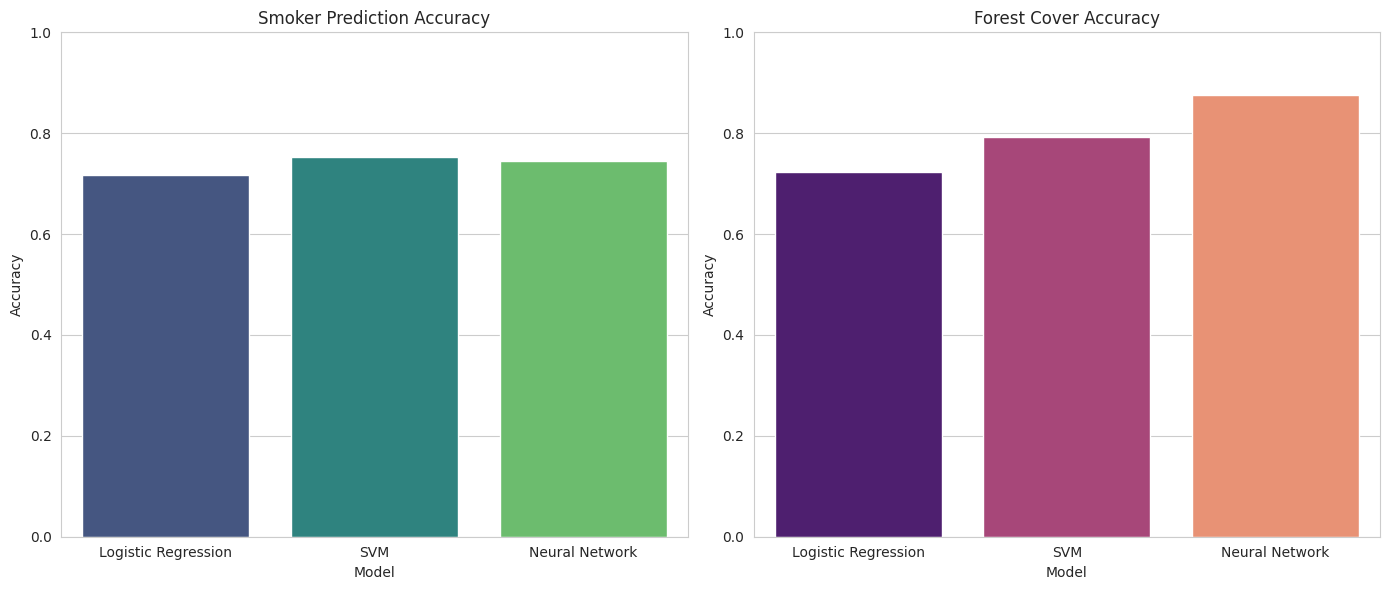

In [ ]:
print("\n====== FINAL COMPARATIVE REPORT ======")

summary_cols = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]

print("\n--- [Smoker Status Prediction - Binary] ---")
print(results_smoker_df[summary_cols].sort_values(by="Accuracy", ascending=False))

print("\n--- [Forest Cover Type - Multiclass] ---")
print(results_forest_df[summary_cols].sort_values(by="Accuracy", ascending=False))

# Conclusion Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x="Model", y="Accuracy", data=results_smoker_df, ax=axes[0], palette="viridis")
axes[0].set_ylim(0, 1.0)
axes[0].set_title("Smoker Prediction Accuracy")

sns.barplot(x="Model", y="Accuracy", data=results_forest_df, ax=axes[1], palette="magma")
axes[1].set_ylim(0, 1.0)
axes[1].set_title("Forest Cover Accuracy")

plt.tight_layout()
plt.show()